# SVM

In [ ]:
!pip uninstall -y gensim numpy
!pip install numpy==1.25.2 gensim==4.3.2

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 22.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.


In [ ]:
!pip uninstall -y scipy
!pip install scipy==1.12.0

Found existing installation: scipy 1.14.1
Uninstalling scipy-1.14.1:
  Successfully uninstalled scipy-1.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 37.4 MB/s eta 0:00:00


In [ ]:
from gensim.models import Word2Vec, Phrases
from gensim.models.phrases import Phraser
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import zipfile
import os
import re

In [ ]:
!wget https://raw.githubusercontent.com/verazuo/a-labelled-version-of-the-ADFA-LD-dataset/refs/heads/master/ADFA-LD.zip


--2025-04-27 17:17:46--  https://raw.githubusercontent.com/verazuo/a-labelled-version-of-the-ADFA-LD-dataset/refs/heads/master/ADFA-LD.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2381193 (2.3M) [application/zip]
Saving to: ‘ADFA-LD.zip’

ADFA-LD.zip         100%[===================>]   2.27M  --.-KB/s    in 0.04s   

2025-04-27 17:17:46 (55.8 MB/s) - ‘ADFA-LD.zip’ saved [2381193/2381193]



In [ ]:
zip_file_path = "/content/ADFA-LD.zip"
# zip_file_path = "/kaggle/working/ADFA-LD.zip"

#extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()  # Change "extracted_folder" if needed

In [ ]:
#paths to dataset folders
train_data_dir = '/content/ADFA-LD/Training_Data_Master'
attack_data_dir = '/content/ADFA-LD/Attack_Data_Master'

# train_data_dir = '/kaggle/working/ADFA-LD/Training_Data_Master'
# attack_data_dir = '/kaggle/working/ADFA-LD/Attack_Data_Master'

data = []

#function to read system calls from a text file
def read_system_calls(file_path):
    with open(file_path, 'r') as file:
        # Read, strip, split, and convert to integers
        system_calls = list(map(int, file.read().strip().split()))
    return system_calls

#function to extract the base attack name (removes last "_" and numbers)
def extract_attack_name(attack_folder_name):
    return re.sub(r'_\d+$', '', attack_folder_name)  # Remove the last "_" and following digits

#process normal system calls (label = 0)
for file_name in os.listdir(train_data_dir):
    file_path = os.path.join(train_data_dir, file_name)
    system_calls = read_system_calls(file_path)
    data.append([system_calls, 'normal', 0])  # Label 0 for normal system calls, 'normal' for the name

#process attack system calls
#mapping attack types to unique labels
attack_label_map = {}
current_label = 1


for attack_folder in os.listdir(attack_data_dir):
    attack_type = extract_attack_name(attack_folder)  #extract the base attack name

    if attack_type not in attack_label_map:
        attack_label_map[attack_type] = current_label
        current_label += 1  #incrementing the label for the next attack type

    attack_label = attack_label_map[attack_type]
    folder_path = os.path.join(attack_data_dir, attack_folder)

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        system_calls = read_system_calls(file_path)
        data.append([system_calls, attack_type, attack_label])  #using the mapped label and attack type for this attack


df = pd.DataFrame(data, columns=['System_Calls', 'Attack_Type', 'Label'])
df.to_csv('system_calls_with_labels.csv', index=False)

In [ ]:
import pandas as pd
import ast
import random

#load original dataset
df = pd.read_csv('/content/system_calls_with_labels.csv')

#parse System_Calls properly
df['System_Calls'] = df['System_Calls'].apply(ast.literal_eval)

#separate attack and normal sequences
attack_df = df[df['Attack_Type'] != 'normal'].copy()
normal_df = df[df['Attack_Type'] == 'normal'].copy()

#harmless syscall IDs
harmless_syscalls = [0, 1, 4, 5, 96]

#parameters
target_count_per_attack_type = 800

#group attack sequences by Attack_Type
augmented_data = []

for attack_type, group in attack_df.groupby('Attack_Type'):
    current_count = len(group)
    augmentations_needed = target_count_per_attack_type - current_count

    print(f"Attack Type: {attack_type} | Current: {current_count} | Need to add: {augmentations_needed}")

    if augmentations_needed <= 0:
        #already enough samples
        augmented_data.append(group)
        continue

    group = group.reset_index(drop=True)

    new_rows = []

    for i in range(augmentations_needed):
        #pick a random attack sequence to augment
        random_row = group.sample(n=1, random_state=random.randint(0, 9999)).iloc[0]
        syscalls = random_row['System_Calls'].copy()

        #random harmless syscalls to prepend and append
        num_prepend = random.randint(5, 15)  #random number of syscalls to prepend
        num_append = random.randint(5, 15)   #random number of syscalls to append

        prepend_syscalls = random.choices(harmless_syscalls, k=num_prepend)
        append_syscalls = random.choices(harmless_syscalls, k=num_append)

        augmented_syscalls = prepend_syscalls + syscalls + append_syscalls

        new_rows.append({
            'System_Calls': augmented_syscalls,
            'Attack_Type': attack_type,
            'Label': random_row['Label']
        })

    #add both original and augmented
    group_augmented = pd.DataFrame(new_rows)
    augmented_data.append(pd.concat([group, group_augmented], ignore_index=True))

#final combined dataset
final_attack_df = pd.concat(augmented_data, ignore_index=True)
final_df = pd.concat([normal_df, final_attack_df], ignore_index=True)

#shuffling
final_df = final_df.sample(frac=1, random_state=42).reset_index(drop=True)

final_df.to_csv('/content/augmented_balanced_system_calls_v2.csv', index=False)

print("Dataset augmented and saved")

Attack Type: Adduser | Current: 91 | Need to add: 709
Attack Type: Hydra_FTP | Current: 162 | Need to add: 638
Attack Type: Hydra_SSH | Current: 176 | Need to add: 624
Attack Type: Java_Meterpreter | Current: 124 | Need to add: 676
Attack Type: Meterpreter | Current: 75 | Need to add: 725
Attack Type: Web_Shell | Current: 118 | Need to add: 682
Dataset augmented and saved


In [ ]:
df_multi = pd.read_csv('/content/augmented_balanced_system_calls_v2.csv')

label_counts = df_multi['Label'].value_counts()
print("\nUnique attack types and their counts:")
print(label_counts)

#converting the System_Calls from string representation to lists of strings, and strip spaces
df_multi['System_Calls'] = df_multi['System_Calls'].apply(lambda x: [elem.strip() for elem in x.strip('[]').split(',')])

df_multi = df_multi.drop(columns=['Attack_Type'])


Unique attack types and their counts:
Label
0    833
6    800
5    800
1    800
2    800
4    800
3    800
Name: count, dtype: int64


In [ ]:
df_multi.dtypes

,0
System_Calls,object
Label,int64


In [ ]:
def read_system_calls(file_path):
    with open(file_path, 'r') as file:
        #read, strip, split, and convert to integers
        system_calls = list(map(int, file.read().strip().split()))
    return system_calls

In [ ]:
#creating validation dataset
val = []
# val_data_dir = "/kaggle/working/ADFA-LD/Validation_Data_Master"
val_data_dir = "/content/ADFA-LD/Validation_Data_Master"
for file_name in os.listdir(val_data_dir):
    file_path = os.path.join(val_data_dir, file_name)
    system_calls = read_system_calls(file_path)
    val.append(system_calls)

#converting each integer to a string
val = [[str(num) for num in sublist] for sublist in val]

In [ ]:
val[0]

['6',
 '6',
 '63',
 '6',
 '11',
 '45',
 '33',
 '192',
 '33',
 '5',
 '197',
 '192',
 '6',
 '33',
 '5',
 '3',
 '197',
 '192',
 '192',
 '6',
 '33',
 '5',
 '3',
 '197',
 '192',
 '192',
 '6',
 '33',
 '5',
 '3',
 '197',
 '192',
 '192',
 '192',
 '192',
 '6',
 '33',
 '5',
 '3',
 '197',
 '192',
 '192',
 '192',
 '6',
 '192',
 '243',
 '125',
 '125',
 '125',
 '125',
 '125',
 '125',
 '91',
 '258',
 '311',
 '240',
 '240',
 '174',
 '174',
 '175',
 '191',
 '122',
 '122',
 '54',
 '78',
 '45',
 '45',
 '5',
 '197',
 '192',
 '192',
 '6',
 '5',
 '5',
 '197',
 '192',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '3',
 '6',
 '91',
 '240',
 '5',
 '197',
 '192',
 '3',
 '3',
 '6',
 '91',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '5',
 '54',
 '5',
 '133',
 '300',
 '5',
 '133',
 '5',
 '221',
 '45',
 '133',
 '220',
 '220',
 '6',
 '300',
 '5',
 '133',
 '220',
 '220',
 '6',
 '5',
 '197',
 '133',
 '6',
 '300',
 '300',
 '300',
 '300',
 '300',
 '300',
 '45

In [ ]:
train_data, test_data = train_test_split(df_multi, test_size=0.20, random_state=42)

In [ ]:
temp = train_data['Label'].value_counts()
print("\nUnique attack types and their counts:")
print(temp)

temp = test_data['Label'].value_counts()
print("\nUnique attack types and their counts:")
print(temp)


Unique attack types and their counts:
Label
5    664
4    653
0    651
1    641
6    637
3    632
2    628
Name: count, dtype: int64

Unique attack types and their counts:
Label
0    182
2    172
3    168
6    163
1    159
4    147
5    136
Name: count, dtype: int64


In [ ]:
print(df_multi.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5633 entries, 0 to 5632
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   System_Calls  5633 non-null   object
 1   Label         5633 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 88.1+ KB
None


In [ ]:
#we need to make sure each item is a list of tokens
def ensure_tokenized(sequences):
    """Convert sequences to lists of tokens if they're not already"""
    tokenized_sequences = []
    for seq in sequences:
        #if the sequence is a string, split it into tokens
        if isinstance(seq, str):
            tokenized_sequences.append(seq.split())
        else:
            #if it's already a list, use it as is
            tokenized_sequences.append(seq)
    return tokenized_sequences

#tokenize both training and testing sequences
train_sequences = ensure_tokenized(train_data['System_Calls'])
test_sequences = ensure_tokenized(test_data['System_Calls'])

#create and apply bigram transformation
bigram = Phrases(train_sequences, min_count=10, threshold=5)
bigram_phraser = Phraser(bigram)
train_bigrams = [bigram_phraser[sequence] for sequence in train_sequences]
test_bigrams = [bigram_phraser[sequence] for sequence in test_sequences]

#create and apply trigram transformation
trigram = Phrases(train_bigrams, min_count=10, threshold=5)
trigram_phraser = Phraser(trigram)
train_trigrams = [trigram_phraser[sequence] for sequence in train_bigrams]
test_trigrams = [trigram_phraser[sequence] for sequence in test_bigrams]

#train Word2Vec model
#set seed and workers for reproducibility
w2v_model = Word2Vec(
    sentences=train_trigrams,
    vector_size=100,  #dimension of the embedding vectors
    window=5,         #context window size
    min_count=1,      #minimum word frequency
    sg=1,             #skip-gram (1) or CBOW (0)
    workers=4,        #number of threads
    seed=42           #for reproducibility
)

#create sequence embeddings
def sequence_to_vec(sequence, model, vector_size=100):
    """Convert a sequence of system calls to a vector using the Word2Vec model"""
    #get vectors for words that exist in the model's vocabulary
    vectors = [model.wv[word] for word in sequence if word in model.wv]

    #return zero vector if none of the words are in vocabulary
    if len(vectors) == 0:
        return np.zeros(vector_size)

    #return average of all word vectors in the sequence
    return np.mean(vectors, axis=0)

#creating vectors for training and testing data
X_train_w2v = np.array([sequence_to_vec(seq, w2v_model) for seq in train_trigrams])
X_test_w2v = np.array([sequence_to_vec(seq, w2v_model) for seq in test_trigrams])

print(f"Training data shape: {X_train_w2v.shape}")
print(f"Testing data shape: {X_test_w2v.shape}")

w2v_model.save("system_call_w2v.model")


Training data shape: (4506, 100)
Testing data shape: (1127, 100)


In [ ]:
# def sequence_to_sequence_vec(sequence, model, vector_size=100, max_len=100):
#     """Convert a sequence of tokens (e.g., system call trigrams) to a fixed-length sequence of vectors."""
#     vectors = []

#     for word in sequence:
#         if word in model.wv:
#             vectors.append(model.wv[word])
#         else:
#             vectors.append(np.zeros(vector_size))  # handle OOV with zero-vector

#     # Truncate or pad
#     if len(vectors) < max_len:
#         # Pad with zero-vectors
#         vectors += [np.zeros(vector_size)] * (max_len - len(vectors))
#     else:
#         # Truncate
#         vectors = vectors[:max_len]

#     return np.array(vectors, dtype=np.float32)

In [ ]:
def sequence_to_sequence_vec(sequence, model, vector_size=100, max_len=100):
    """Convert a sequence of system calls to a sequence of vectors (no averaging)"""
    vectors = [model.wv[word] for word in sequence if word in model.wv]

    #pad or truncate to max_len
    if len(vectors) < max_len:
        #pad with zeros
        vectors += [np.zeros(vector_size)] * (max_len - len(vectors))
    else:
        #truncate if too long
        vectors = vectors[:max_len]

    return np.array(vectors)

In [ ]:
y_train = train_data['Label']
y_test = test_data['Label']

In [ ]:
#process validation data with the same pipeline as training/testing
#apply bigram transformation to validation data
val_bigrams = [bigram_phraser[sequence] for sequence in val]

#apply trigram transformation to validation data
val_trigrams = [trigram_phraser[sequence] for sequence in val_bigrams]

#create vectors for validation data using the same model and function
X_val = np.array([sequence_to_vec(seq, w2v_model) for seq in val_trigrams])

#create labels for validation data (all 0s as specified)
y_val = np.zeros(len(val))

print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

Validation data shape: (4372, 100)
Validation labels shape: (4372,)


In [ ]:
y_val

array([0., 0., 0., ..., 0., 0., 0.])

Accuracy: 0.7782

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       182
           1       0.59      0.89      0.71       159
           2       0.73      0.85      0.78       172
           3       0.61      0.69      0.65       168
           4       0.99      0.80      0.89       147
           5       0.95      0.68      0.79       136
           6       0.89      0.51      0.65       163

    accuracy                           0.78      1127
   macro avg       0.82      0.77      0.78      1127
weighted avg       0.81      0.78      0.78      1127



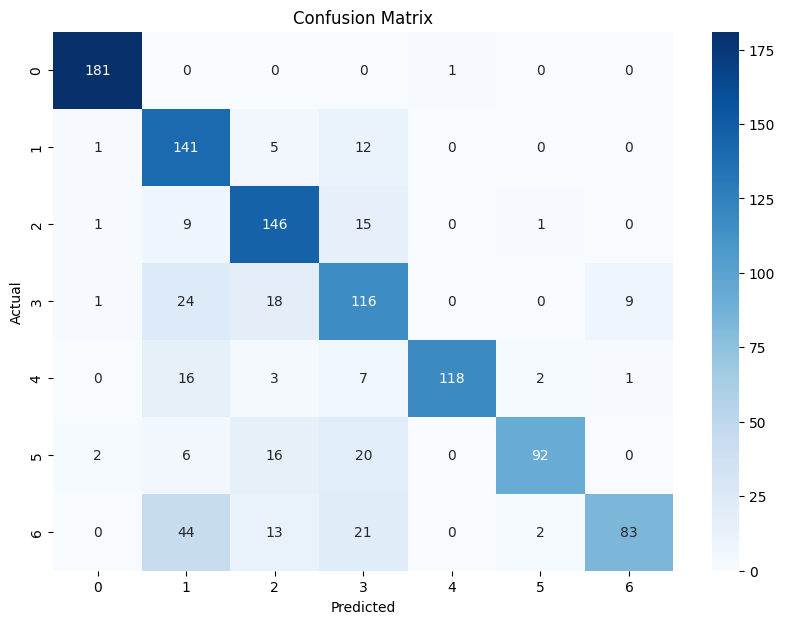

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert labels to numpy arrays
# y_train = y_train.values
# y_test = y_test.values

# Feature Scaling (critical for SVM performance)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

svm_classifier = SVC(
    # class_weight={0: 1, 1: 5, 2: 10, 3: 10, 4: 10, 5: 5, 6: 10},  # Auto-adjust weights inversely proportional to class frequencies
    kernel='rbf',
    C=1,
    gamma=5,
    decision_function_shape='ovr',
    random_state=42
)

svm_classifier.fit(X_train_w2v, y_train)

y_pred = svm_classifier.predict(X_test_w2v)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Validation Results:
Accuracy: 0.8710

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      4372
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0

    accuracy                           0.87      4372
   macro avg       0.14      0.12      0.13      4372
weighted avg       1.00      0.87      0.93      4372



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


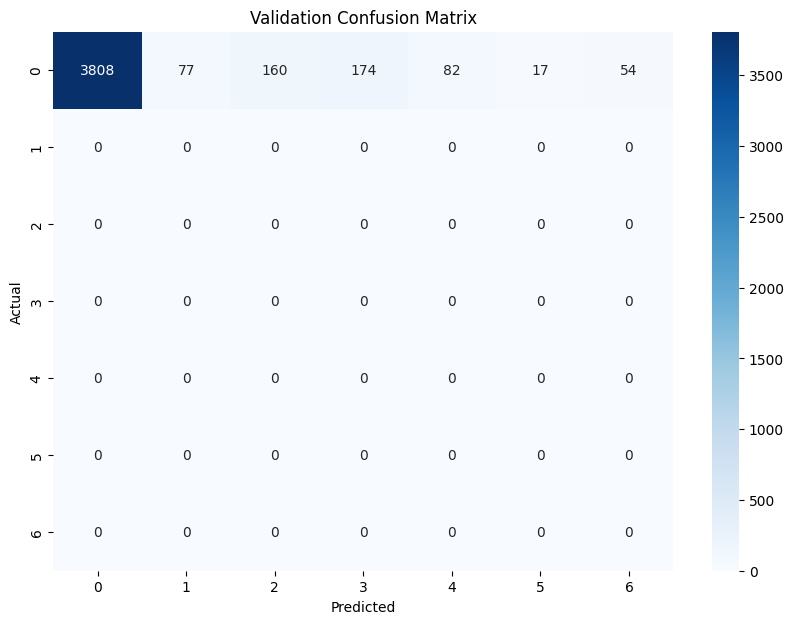

In [ ]:
val_predictions = svm_classifier.predict(X_val)

print("Validation Results:")
print(f"Accuracy: {accuracy_score(y_val, val_predictions):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, val_predictions))

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_val, val_predictions),
            annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix')
plt.show()


Accuracy: 0.9139

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       182
           1       0.86      0.94      0.90       159
           2       0.91      0.95      0.93       172
           3       0.86      0.88      0.87       168
           4       0.95      0.91      0.93       147
           5       0.95      0.89      0.92       136
           6       0.89      0.82      0.86       163

    accuracy                           0.91      1127
   macro avg       0.92      0.91      0.91      1127
weighted avg       0.91      0.91      0.91      1127



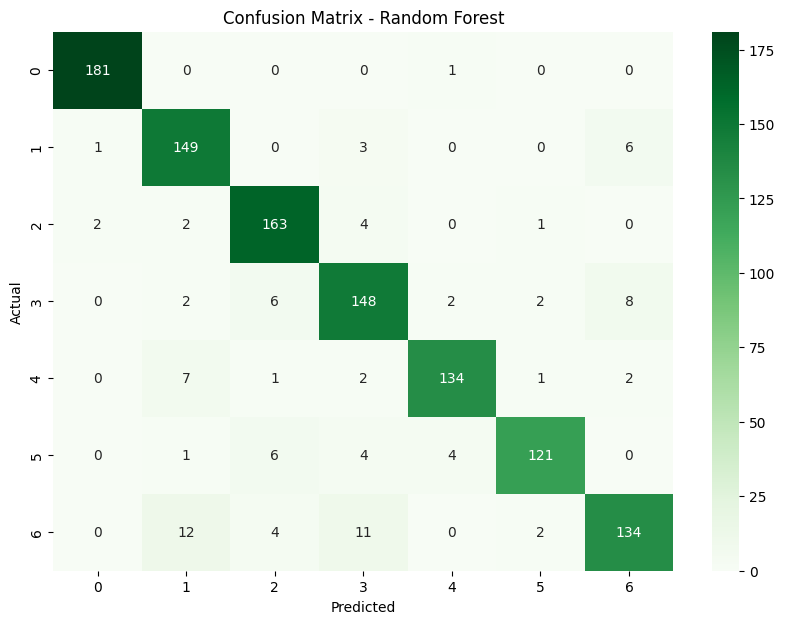

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


rf_classifier = RandomForestClassifier(
    n_estimators=100,         #number of trees
    max_depth=None,           #expanding until all leaves are pure or contain less than min_samples_split
    # class_weight={0: 1, 1: 5, 2: 10, 3: 10, 4: 10, 5: 5, 6: 10},  #used for handling class imbalance
    random_state=42,
    n_jobs=-1                 #using all available CPU cores
)

rf_classifier.fit(X_train_w2v, y_train)

y_pred = rf_classifier.predict(X_test_w2v)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()


Validation Results:
Accuracy: 0.8406

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91      4372
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0

    accuracy                           0.84      4372
   macro avg       0.14      0.12      0.13      4372
weighted avg       1.00      0.84      0.91      4372



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


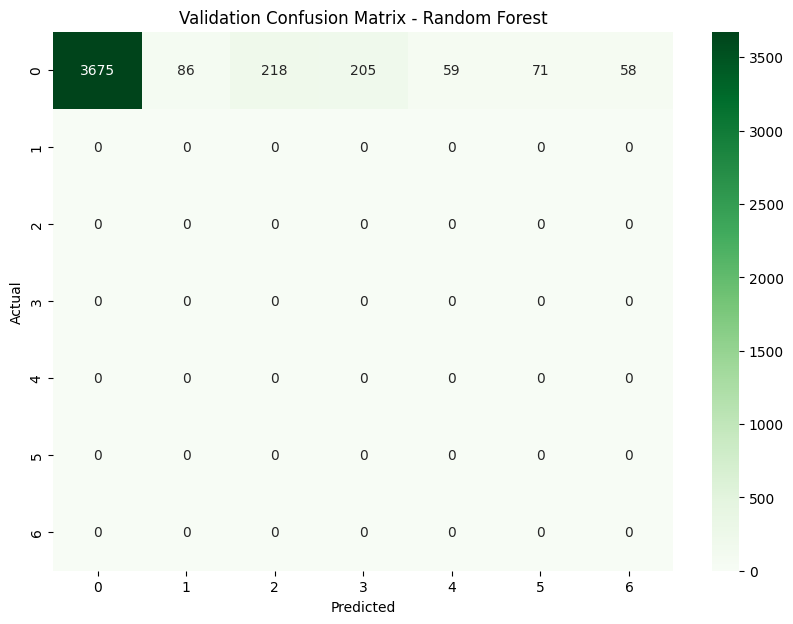

In [ ]:
#predictions
val_predictions = rf_classifier.predict(X_val)

print("Validation Results:")
print(f"Accuracy: {accuracy_score(y_val, val_predictions):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, val_predictions))

#confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_val, val_predictions),
            annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Confusion Matrix - Random Forest')
plt.show()


# ANN

# ANN

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [ ]:
print(X_train_w2v.shape)

(4506, 100)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

#categorical labels
num_classes = 7
y_train_cat = to_categorical(y_train, num_classes=num_classes)

#dense classifier
model = Sequential()
model.add(Dense(256, input_shape=(100,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

model.fit(X_train_w2v, y_train_cat, epochs=500, batch_size=64, validation_split=0.1, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.2147 - loss: 1.8955 - val_accuracy: 0.3836 - val_loss: 1.6200
Epoch 2/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3392 - loss: 1.6794 - val_accuracy: 0.4789 - val_loss: 1.4105
Epoch 3/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3877 - loss: 1.5266 - val_accuracy: 0.5410 - val_loss: 1.2673
Epoch 4/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4596 - loss: 1.3984 - val_accuracy: 0.5610 - val_loss: 1.2102
Epoch 5/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4589 - loss: 1.3404 - val_accuracy: 0.5765 - val_loss: 1.1569
Epoch 6/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4697 - loss: 1.2908 - val_accuracy: 0.5920 - val_loss: 1.0977
Epoch 7/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5219 - loss: 1.2074 - val_accuracy: 0.6142 - val_loss: 1.0710
Epoch 8/500
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5214 - loss: 1.1790 - val_accuracy: 0.6009 - 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


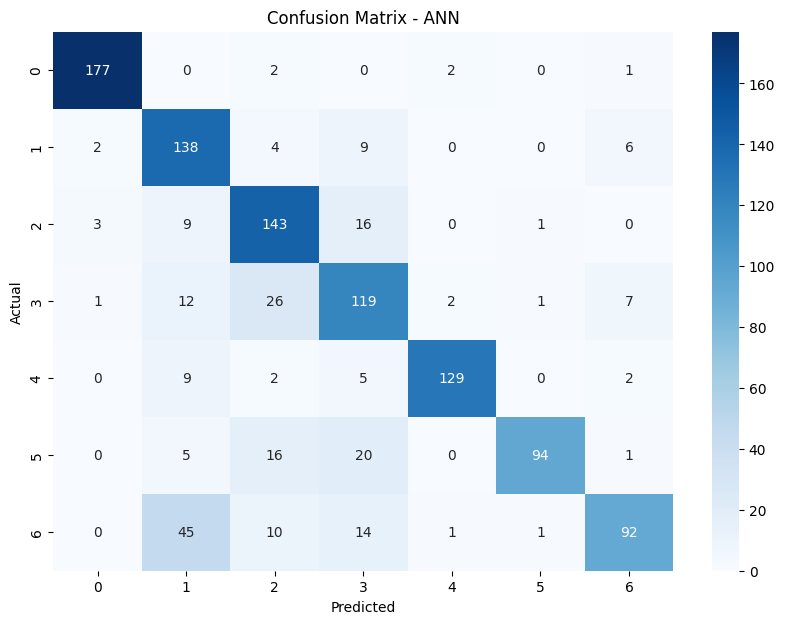

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       182
           1       0.63      0.87      0.73       159
           2       0.70      0.83      0.76       172
           3       0.65      0.71      0.68       168
           4       0.96      0.88      0.92       147
           5       0.97      0.69      0.81       136
           6       0.84      0.56      0.68       163

    accuracy                           0.79      1127
   macro avg       0.82      0.79      0.79      1127
weighted avg       0.81      0.79      0.79      1127



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#assuming 'model' and 'X_test_w2v' are defined as in your provided code

#make predictions on the test set
y_pred_prob = model.predict(X_test_w2v)
y_pred = np.argmax(y_pred_prob, axis=1)


#confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ANN')
plt.show()

#classification Report
print(classification_report(y_test, y_pred))


# LSTM

In [ ]:
max_len = 1200  #adjust based on typical sequence length
embedding_dim = 100  #matches vector_size in Word2Vec

X_train_lstm = np.array([sequence_to_sequence_vec(seq, w2v_model, embedding_dim, max_len) for seq in train_trigrams])
X_test_lstm = np.array([sequence_to_sequence_vec(seq, w2v_model, embedding_dim, max_len) for seq in test_trigrams])

print(X_train_lstm.shape)  #this should be like (samples, max_len, embedding_dim)

(4506, 1200, 100)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LayerNormalization

In [ ]:
from keras.regularizers import l2

In [ ]:
#one-hot encode labels
num_classes = 7
y_train_cat = to_categorical(y_train, num_classes=num_classes)

model2 = Sequential()
#add Bidirectional LSTM layers
model2.add(Bidirectional(LSTM(128, return_sequences=True)))
model2.add(LayerNormalization())
model2.add(Dropout(0.5))
model2.add(Bidirectional(LSTM(64)))
model2.add(LayerNormalization())

#fully connected layers
model2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.04)))
model2.add(Dropout(0.4))

#output layer
model2.add(Dense(7, activation='softmax'))

model2.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# model2.fit(X_train_lstm, y_train_cat, epochs=100, batch_size=64,
#           validation_split=0.1, verbose=1, class_weight=class_weights,
#           callbacks=[early_stop, reduce_lr])

model2.fit(X_train_lstm, y_train_cat, epochs=100, batch_size=64,
          validation_split=0.1, verbose=1,
          callbacks=[early_stop, reduce_lr])



Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 282ms/step - accuracy: 0.3808 - loss: 4.9996 - val_accuracy: 0.5827 - val_loss: 3.9035 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.5325 - loss: 3.9316 - val_accuracy: 0.6299 - val_loss: 3.2761 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - accuracy: 0.5460 - loss: 3.3219 - val_accuracy: 0.6063 - val_loss: 2.7175 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.5868 - loss: 2.7539 - val_accuracy: 0.6142 - val_loss: 2.3340 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.5959 - loss: 2.4311 - val_accuracy: 0.6063 - val_loss: 2.0782 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - accuracy: 0.6075 - loss: 2.1677 - val_accuracy: 0.6850 - val_loss: 1.7722 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.6349 - loss: 

In [ ]:
#classification_report for lstm

from sklearn.metrics import classification_report


y_pred_lstm = model2.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)

print(classification_report(y_test, y_pred_lstm))


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       178
           1       0.14      0.43      0.21         7
           2       0.55      0.44      0.49        25
           3       0.17      0.05      0.08        20
           4       0.72      0.62      0.67        37
           5       0.53      0.64      0.58        25
           6       0.50      0.42      0.45        24

    accuracy                           0.75       316
   macro avg       0.51      0.51      0.49       316
weighted avg       0.75      0.75      0.74       316



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


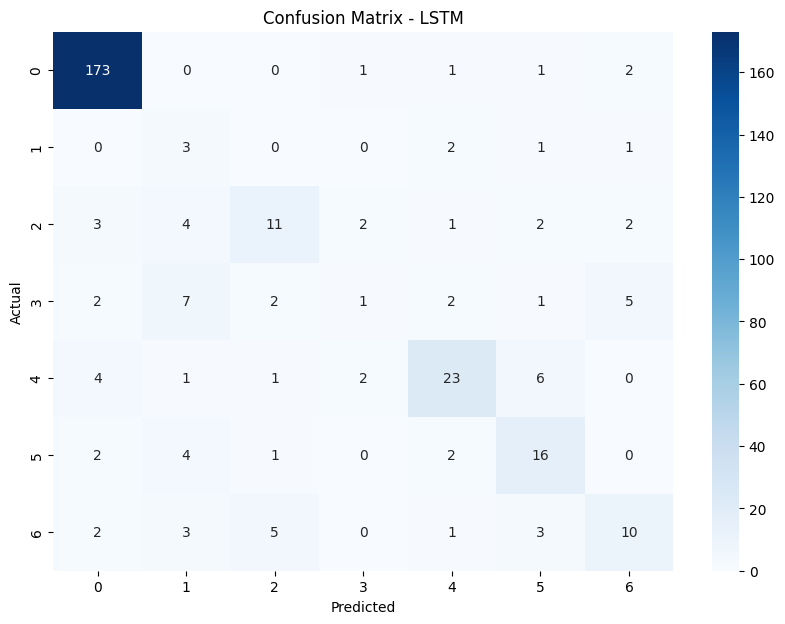

In [ ]:
#confusion matrix for lstm

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_pred_lstm = np.argmax(model2.predict(X_test_lstm), axis=1)

cm_lstm = confusion_matrix(y_test, y_pred_lstm)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()


# GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout, LayerNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

#one-hot encoding the labels
num_classes = 7
y_train_cat = to_categorical(y_train, num_classes=num_classes)

model_gru = Sequential()
model_gru.add(Bidirectional(GRU(128, return_sequences=True)))
model_gru.add(LayerNormalization())
model_gru.add(Dropout(0.5))
model_gru.add(Bidirectional(GRU(64)))
model_gru.add(LayerNormalization())

#fully connected layers
model_gru.add(Dense(64, activation='relu', kernel_regularizer=l2(0.04)))
model_gru.add(Dropout(0.4))

#output layer
model_gru.add(Dense(7, activation='softmax'))

model_gru.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_gru.fit(X_train_lstm, y_train_cat, epochs=100, batch_size=64,
              validation_split=0.1, verbose=1, class_weight=class_weights,
              callbacks=[early_stop, reduce_lr])


In [ ]:
#classification_report


from sklearn.metrics import classification_report


y_pred_gru = np.argmax(model_gru.predict(X_test_lstm), axis=1)

print(classification_report(y_test, y_pred_gru))


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       178
           1       0.13      0.57      0.21         7
           2       0.57      0.52      0.54        25
           3       0.54      0.70      0.61        20
           4       0.57      0.65      0.61        37
           5       0.62      0.60      0.61        25
           6       1.00      0.25      0.40        24

    accuracy                           0.75       316
   macro avg       0.63      0.60      0.56       316
weighted avg       0.82      0.75      0.76       316



10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


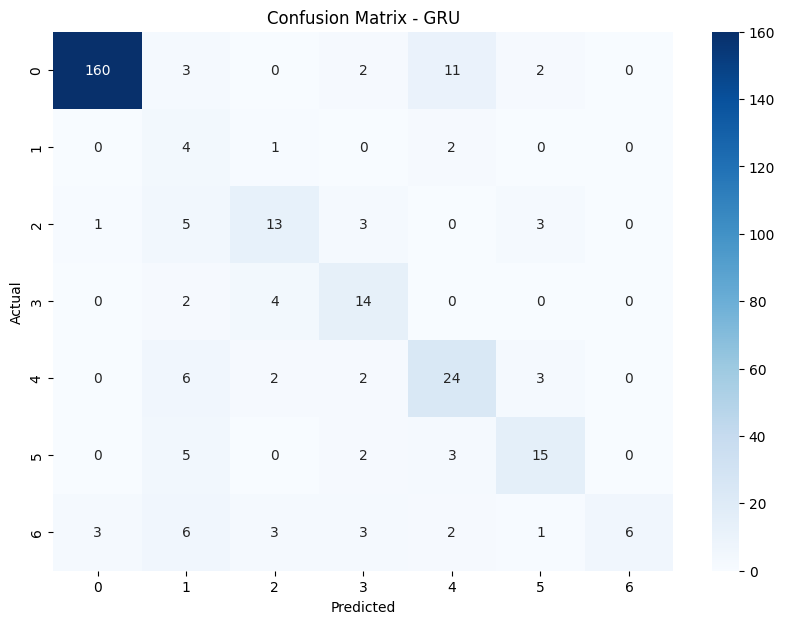

In [ ]:
#confusion matrix for gru

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


y_pred_gru = np.argmax(model_gru.predict(X_test_lstm), axis=1)

cm_gru = confusion_matrix(y_test, y_pred_gru)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - GRU')
plt.show()


# Attention Based Transformer Encoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dense, Dropout, Embedding

class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None): #added training=None as default
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

embed_dim = 100  #set to the dimension of your word embeddings
num_heads = 2  #number of attention heads
ff_dim = 32  #hidden layer size in feed forward network
num_classes = len(label_counts)  #number of classes in your dataset

inputs = keras.Input(shape=(100, embed_dim)) #assuming fixed input sequence length
x = TransformerEncoder(embed_dim, num_heads, ff_dim)(inputs)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(20, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

X_train_seq = np.array([sequence_to_sequence_vec(seq, w2v_model) for seq in train_trigrams])
X_test_seq = np.array([sequence_to_sequence_vec(seq, w2v_model) for seq in test_trigrams])


model.fit(X_train_seq, y_train, batch_size=32, epochs=50)  #adjust batch size and epochs

#evaluate the model
loss, accuracy = model.evaluate(X_test_seq, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.2889 - loss: 1.8055
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4601 - loss: 1.3204
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5145 - loss: 1.2162
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5075 - loss: 1.1727
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5639 - loss: 1.1213
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5775 - loss: 1.0552
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5866 - loss: 1.0372
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5848 - loss: 1.0348
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5925 - loss: 0.9900
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5988 - loss: 0.9948
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6154 - loss: 0.9719
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/st

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       182
           1       0.53      0.83      0.64       159
           2       0.75      0.70      0.72       172
           3       0.57      0.64      0.60       168
           4       0.95      0.52      0.68       147
           5       0.71      0.76      0.73       136
           6       0.71      0.48      0.58       163

    accuracy                           0.71      1127
   macro avg       0.74      0.70      0.70      1127
weighted avg       0.74      0.71      0.70      1127



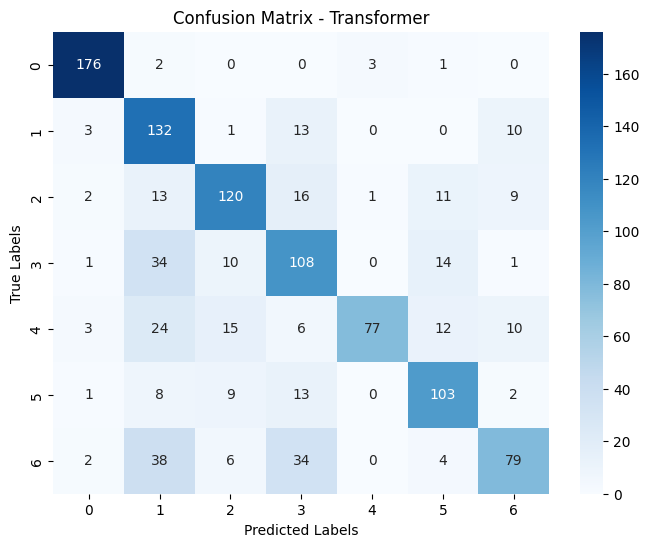

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#make predictions on the test set
y_pred = model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)

#generate the classification report
print(classification_report(y_test, y_pred_classes))

#generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Transformer")
plt.show()
